![polytechnic of tehran](https://www.irangi.org/uploads/images/4_1560089256_1291127534.png)
<div style="text-align:center"><span style="color:blue; font-family:Georgia; font-size:2em;">Python code of the Project about classification in NLP</span></div>.

<div style="text-align:center"><span style="color:blue; font-family:Georgia; font-size:2em;">Professor: Dr. M.Akbari (akbari.ma@aut.ac.ir)</span></div>.     

<div style="text-align:center"><span style="color:blue; font-family:Georgia; font-size:2em;">
    TAs: A.Malekzade(malekzadeh@ieee.org) , Y.Ommi(yassi.ommi@gmail.com)</span></div>.

<div style="text-align:center"><span style="color:blue; font-family:Georgia; font-size:2em;">Student: Mohammadreza Ardestani (ardestani.zr@gmail.com)</span></div>

<div style="text-align:center"><span style="color:blue; font-family:Georgia; font-size:2em;">9513004</span></div>.



Date: 5,Nov,2020



## Outline:we're going to design a classifier for tweets about the USA airline.

# Phase 1) Preprocessing the data and preparing it 

In [766]:
## __________________Importing Libs _____________ 
import csv 
import os
import numpy as np
import matplotlib.pyplot as plt

In [767]:
##________________________________ Extracting tweets and sentiments ____________________________

All_texts = [] # list of all tweets in Train set
All_sent = [] # name of the sentiment categories in train set
testTweetsList = [] # list of all tweets in test set
testSentimentList = [] # name of the sentiment of the tweets in the  test set
devTweetsList = [] # list of all tweets in dev set
devSentimentList =[] # sentiment's name of the tweets in the  dev set

trainFilePath = 'airline-train.csv'
testFilePath = 'airline-test.csv'
devFilePath = 'airline-dev.csv'
def extractor(path,column):
    list=[]
    with open(path,'r',encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            list.append(row[column])
        return list

All_texts = extractor(trainFilePath,15)
All_sent = extractor(trainFilePath,6)
testTweetsList = extractor(testFilePath,15)
testSentimentList = extractor(testFilePath,6)
devTweetsList = extractor(devFilePath,15)
devSentimentList = extractor(devFilePath,6)


In [768]:
#______________________________________ Removing Usernames __________________________
def UserNameRemover(list):
    new_list = []
    for i in list:
        i = " ".join(filter(lambda x:x[0]!='@', i.split()))
        new_list.append(i)
        
    return new_list
#______________________________________ Removing URLs __________________________
import re  ## importing regular expresions 
def URLremover(list):
    j=0
    for txt in list:
        list[j] = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', txt)
        #list[j] = re.sub(r'^http?:\/\/.*[\r\n]*', ' ', txt)
        j+=1
    return list

## ____________________ Converting emojies to its equivalent word _________________  
## For example converting :) to smile or ;) to blink or :( to sad 
        
##  ______________________ removing punctuations ___________
import string 
def punctuationRemover(list):
    punc = string.punctuation
    j=0
    for txt in list:
        list[j] = "".join([c for c in txt if c not in punc])
        j+=1
    return list
## _____________________________ Making Lower case _______________
## 'it' is stopword but 'It' is not stopword for solving this problem we need to make all characters Lower case 
def LowerCaseAll(list):
    j = 0
    for txt in list:
        list[j]=txt.lower()
        j+=1
##________________________ Removing numbers _________________________
def NumberRemover(list):
    j=0
    for txt in list:
        list[j] = "".join([c for c in txt if not c.isdigit()])
        j+=1

##________________________ Removing stop words _______________
import nltk as nl
stopwords = nl.corpus.stopwords.words('english')
def StopWordsRemover(list):
    j=0
    for txt in list:
        tokens = txt.split(" ")
        CleanedText= ""
        for token in tokens:
            if(token not in stopwords):
                CleanedText += (token + " ")
        list[j]= CleanedText
        j+=1
##____________________ Stemming Phase  _____________________
## 
import nltk
from nltk import PorterStemmer 
ps = PorterStemmer()
def stemmer(list):
    j=0
    for txt in list:
        tokens = txt.split(" ")
        tokens = [ tok for tok in tokens if not(tok=='')] # removing White space
        cleanline=""
        k=0
        for tok in tokens:
            if len(tok)>2: #removing tokend with length less than 3 
                cleanline += (ps.stem(tok)+" ")
                k+=1
                
        # cleanline has one redundent white space at the end, Better to remove it
        cleanline = cleanline[:-1]
        list[j] = cleanline # saving the result
        j+=1


In [769]:
def listOfTweetsCleaner(list):
    list = UserNameRemover(list)
    list = URLremover(list)
    list = punctuationRemover(list)
    LowerCaseAll(list)
    NumberRemover(list)
    StopWordsRemover(list)
    stemmer(list)
    return list
    
def TextCleaner(string):
    list = [string]
    list = UserNameRemover(list)
    list = URLremover(list)
    list = punctuationRemover(list)
    LowerCaseAll(list)
    NumberRemover(list)
    StopWordsRemover(list)
    stemmer(list)
    # at the end we return list of words 
    listOfWords = list[0].split(" ")
    return listOfWords
    
##_______________________ Normalizing ________________________
## _______________________ handeling negation__________________
##___________________ removing words with less than 2 char ________________
    

In [770]:
## cleaning tweets in train,test,dev set
All_texts = listOfTweetsCleaner(All_texts)
testTweetsList = listOfTweetsCleaner(testTweetsList)
devTweetsList = listOfTweetsCleaner(devTweetsList)

# Phase 2) Opting the best features with CHI-SQUARE method

In [771]:
## At this point we are going to extract bag of words for each category 
## And then, we select the best features(/word /tocken)
Pbag = {} # Bag of words in Positive tweets and their number of occurrence (empty Dictionary )
Nbag= {} # Negative 
bag = {} # Neutral

def DicUpdator(Dic, str):
    words = str.split(" ")
    for w in words:
        if w in Dic:
            Dic[w] +=1
        else:
            Dic[w] = 1

def BagBuilder(CategoryList, TextList , pb , nb , b):
    j=0
    for cat in CategoryList:
        if cat == "positive":
            DicUpdator(pb, TextList[j])
        if cat == "negative":
            DicUpdator(nb, TextList[j])
        if cat == "neutral":
            DicUpdator(b, TextList[j])
        j+=1
## Finding the total number of tweets for each category
All_pos=0
All_neg= 0
All_neu=0
N=0
for cat in All_sent:
    if cat == "positive":
        All_pos +=1
    if cat == "negative":
        All_neg +=1
    if cat == "neutral":
        All_neu +=1
N = All_pos + All_neg + All_neu

BagBuilder(All_sent, All_texts, Pbag, Nbag, bag)


In [772]:
## Now we use CHI-SQUATE TEST  to figure out which word has discrimination power

## Assumption before usign All_neg/_pos/_neu in Chi-square method is that after
## cleaning the data we don't have any word that has occurred in one tweet more than one time

# format of following 3 dictionaies :('word',"its Chi-square value ")
# In other words, if x is an element of FPbag it x is 
# equal to ("word that has occurred in positive tweets", "it's Chi-squ value value for category of POSITIVE")


FPbag= {} # Fianl words (selected features) in each bag which have discrimination power
FNbag = {} # Final bag of words of negative category
Fbag = {}  # Neutral     
 
def ChiSquare(fp, fn, f):# passing positive/negative/neutral Final Dictionaries 
    # Processing Possitive bag:
    for word,value in Pbag.items():
        A = value
        C = All_pos - A
        if word in Nbag:
            N1= Nbag[word]
        else:
            N1=0
        if word in bag:
            N2= bag[word]
        else:
            N2=0
        B = N1 + N2
        D = All_neu + All_neg - B 
        X = ( (N*(A*D-C*B))/((A+C)*(B+D)*(A+B)*(C+D) ) )
        fp[word]=round(X*1000,3)
        
    # Processing Negative bag:
    for word,value in Nbag.items():
        A = value
        C = All_neg - A
        if word in Pbag:
            N1= Pbag[word]
        else:
            N1=0
        if word in bag:
            N2= bag[word]
        else:
            N2=0
        B = N1 + N2
        D = All_neu + All_pos - B 
        X = ( (N*(A*D-C*B))/((A+C)*(B+D)*(A+B)*(C+D) ) )
        fn[word]=round(X*10000,3)
        
    # Processing Neutral bag:
    for word,value in bag.items():
        A = value
        C = All_neu - A
        if word in Pbag:
            N1= Pbag[word]
        else:
            N1=0
        if word in Nbag:
            N2= Nbag[word]
        else:
            N2=0
        B = N1 + N2
        D = All_pos + All_neg - B 
        X = ( (N*(A*D-C*B))/((A+C)*(B+D)*(A+B)*(C+D) ) )
        f[word]= round(X*10000,3)

In [773]:
ChiSquare(FPbag,FNbag,Fbag)

In [774]:
### Now that we have calculated CHI_Square value of all features, we gonna select best of them (those whitch have
##  CHI_Sq value more than 0.1 )

def SelectBest(Dic):
    temp_dic = {}
    for word,value in Dic.items():
        if value > 0.1:
            temp_dic[word]=value
    return temp_dic
FPbag = SelectBest(FPbag)
FNbag = SelectBest(FNbag)
Fbag = SelectBest(Fbag)
#print(len(FPbag)+len(FNbag)+len(Fbag))

# Phase 3,4,5 ) Implementing Naïve Bayes,Primarily classifier, Improving the classifier 

In [775]:
##||||||||                ||||||||||||      Phase 3,4,5       ||||||||                  ||||||||||||||
## In this part we gonna design a classifier _Based on Naive bayse method _ for Phase 3
## Then we build a primarly calssifier based on last phase for phase 4
## we Try to optimize it for phase 5 

# At first we calculate Probability of every word (/feature) give i'th category
def Counting_Helper(dic):
    sum =0
    for word,frequency in dic.items():
        sum+=frequency
    return sum
def Probability_calculater(dic, Total_Num):
    temp_dic = {}
    for word,frequency in dic.items():
        temp_dic[word]= ((frequency+1)/(Total_Num+len(dic)))
    return temp_dic


Total_Words_P = Counting_Helper(Pbag) #Total number of words in category "Positive"
Total_Words_N = Counting_Helper(Nbag) #Total number of words in category "Negative"
Total_Words =  Counting_Helper(bag)   #Total number of words in category "Neutral"
Prob_P = Probability_calculater(Pbag, Total_Words_P) # " Feature_in_cate_Positive : P(feature Given category_positive)"
Prob_N =Probability_calculater(Nbag, Total_Words_N) # " Feature_in_cate_Negative : P(feature Given category_negative) "
Prob =Probability_calculater(bag, Total_Words)   # " Feature_in_cate_Neutral  : P(feature Given category_neutral) "


def Probability(lst,cateName):
    value = 1
    if cateName == "positive":
        for word in lst:
            if word in Prob_P:
                value *= Prob_P[word]
            else:
                value *= (1/((Total_Words_P+len(Prob_P))))
    if cateName == "negative":
        for word in lst:
            if word in Prob_N:
                value *= Prob_N[word]
            else:
                value *= (1/((Total_Words_N+len(Prob_N))))
    if cateName == "neutral":
        for word in lst:
            if word in Prob:
                value *= Prob[word]
            else:
                value *= (1/((Total_Words_P+len(Prob))))
    return value
                


## Naive Bayse Classifier :
def Classifier(string):
    CleanList = TextCleaner(string)#clean list of words
    resultDic={}
    resultDic["positive"] = Probability(CleanList, "positive")
    resultDic["negative"] = Probability(CleanList, "negative")
    resultDic["neutral"] = Probability(CleanList, "neutral")
    resultDic = sorted(resultDic.items(), key=lambda x: x[1], reverse=True)#reultDic is no longer a dic (It's a list)
    return resultDic[0][0] 

    


In [776]:
#print(Classifier("@united no, didn't notice I was 38A until start of boarding. Assumed I was 8E."))
# successful result for classifying 

# Phase 6) Calculating Precision, Recall, F1, Confusion Matrix 

In [777]:
## Final phase 
## In the final phase we use testSet, and devset data to find Precision, Recall , F1,and Confusion Matrix of classifier
#following function give a list of tweets and return list of estimated sentiment
def ClassifierOfList(list):
    tempList=[]
    for txt in list:
        tempList.append(Classifier(txt))
    return tempList

testEstimated=ClassifierOfList(testTweetsList) #  estimated sentiment of testset
devEstimated=ClassifierOfList(devTweetsList) #  estimated sentiment of devset


In [782]:
##Now we design a function to show Precision,Recall,F_1,ConfusionMatrix graphically
def entriesOfConfusionMatrixCalculator(tp, fp, fn, tn, m):
    acc = (tp + tn) / m
    pre = tp / (tp + fp)
    recall = tp / (tp + fn)
    f = 2*pre*recall / (pre + recall)
    return acc, pre, recall, f
    
def PlotEvalutaionResult(Y, predict):
    pos_pos = 0
    pos_net = 0
    pos_neg = 0
    net_pos = 0
    net_net = 0
    net_neg = 0
    neg_pos = 0
    neg_net = 0
    neg_neg = 0
    m = len(Y)
    for i in range(m):
        if Y[i] == "positive":
            if predict[i] == "positive":
                pos_pos += 1
            elif predict[i] == "neutral":
                pos_net += 1
            else:
                pos_neg += 1
        elif Y[i] == "neutral":
            if predict[i] == "positive":
                net_pos += 1
            elif predict[i] == "neutral":
                net_net += 1
            else:
                net_neg += 1
        else:
            if predict[i] == "positive":
                neg_pos += 1
            elif predict[i] == "neutral":
                neg_net += 1
            else:
                neg_neg += 1
    # positive
    tp_pos = pos_pos
    fn_pos = pos_neg + pos_net
    fp_pos = neg_pos + net_pos
    tn_pos = m - tp_pos - fn_pos - fp_pos
    acc_pos, pre_pos, recall_pos, f_pos = entriesOfConfusionMatrixCalculator(tp_pos, fp_pos, fn_pos, tn_pos, m)
    
    
    # negative
    tp_neg = neg_neg
    fn_neg = neg_pos + neg_net
    fp_neg = pos_neg + net_neg
    tn_neg = m - tp_neg - fn_neg - fp_neg
    acc_neg, pre_neg, recall_neg, f_neg = entriesOfConfusionMatrixCalculator(tp_neg, fp_neg, fn_neg, tn_neg, m)
    
    # neutral
    tp_net = net_net
    fn_net = net_pos + net_neg
    fp_net = pos_net + neg_net
    tn_net = m - tp_net - fn_net - fp_net
    acc_net, pre_net, recall_net, f_net = entriesOfConfusionMatrixCalculator(tp_net, fp_net, fn_net, tn_net, m)
    
    # plot confusion matrix
    data_pos = np.array([['Confusion Matrix (positive)', 'correct', 'not-correct'], ['selected', tp_pos, fp_pos]
                     ,['not-selected' , fn_pos, tn_pos]])
    data_neg = np.array([['Confusion Matrix (negative)', 'correct', 'not-correct'], ['selected', tp_neg, fp_neg]
                     ,['not-selected' , fn_neg, tn_neg]])
    data_net = np.array([['Confusion Matrix (neutral)', 'correct', 'not-correct'], ['selected', tp_net, fp_net]
                     ,['not-selected' , fn_net, tn_net]])

    fig, axs = plt.subplots(4)

    The_Table = axs[0].table(cellText=data_pos, loc='center',cellLoc='center')
    The_Table.set_fontsize(10)
    The_Table.scale(1.5, 1.5)
    axs[0].axis('off')
    #axs[0].title('Confusion matrix')

    The_Table = axs[1].table(cellText=data_neg, loc='center',cellLoc='center')
    The_Table.set_fontsize(10)
    The_Table.scale(1.5, 1.5)
    axs[1].axis('off')
    #axs[1].title('Confusion matrix')

    The_Table = axs[2].table(cellText=data_net, loc='center',cellLoc='center')
    The_Table.set_fontsize(10)
    The_Table.scale(1.5, 1.5)
    axs[2].axis('off')
    #axs[2].title('Confusion matrix')
    
    data = np.array([['', 'accuracy', 'precision', 'recall', 'F_1'],
                    ['positive', round(acc_pos,5), round(pre_pos,5), round(recall_pos,5), round(f_pos,5)],
                    ['negative', round(acc_neg,5), round(pre_neg,5), round(recall_neg,5), round(f_neg,5)],
                   ['neutral', round(acc_net,5), round(pre_net,5), round(recall_net,5), round(f_net,5)]])
    
    The_Table = axs[3].table(cellText=data, loc='center',cellLoc='center')
    The_Table.set_fontsize(10)
    The_Table.scale(1.2, 1.2)
    axs[3].axis('off')
    #axs[2].title('Confusion matrix')

    #seting every cell settings

    plt.savefig("table.png") 
    
    acc = (pos_pos + neg_neg + net_net) / m * 100
    
    

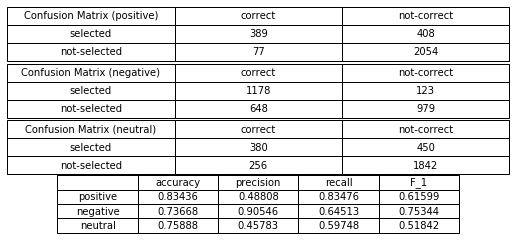

In [783]:
## ploting the graph of TestSet
PlotEvalutaionResult(testSentimentList[1:],testEstimated[1:])


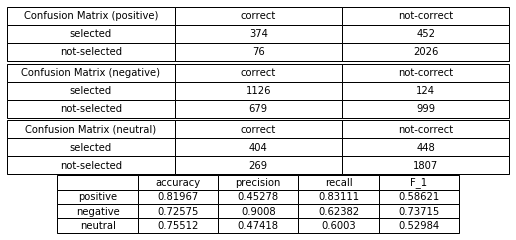

In [784]:
## ploting the graph of devSet
PlotEvalutaionResult(devSentimentList[1:],devEstimated[1:])

#  _   _   _                              ** Enter your query here** 

In [781]:
testString = "past your tweet here, and then run this cell to get the result"
print(Classifier(testString))

neutral
